In [1]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm
import random
import matplotlib
import plotnine
from plotnine import ggplot, aes, geom_point, geom_jitter, geom_smooth, geom_histogram, geom_line, geom_errorbar, stat_smooth, geom_ribbon
from plotnine.facets import facet_wrap
import seaborn as sns
import theano.tensor as tt
from scipy.special import expit
from scipy.special import logit
from scipy.stats import cauchy
from sklearn.metrics import roc_auc_score
from skmisc.loess import loess
import warnings
warnings.filterwarnings("ignore") # plotnine is causing all kinds of matplotlib warnings


## Define custom functions

invlogit = lambda x: 1/(1 + tt.exp(-x))

def trace_predict(trace, X):
    y_hat = np.apply_along_axis(np.mean, 1, expit(trace['alpha'] + np.dot(X, np.transpose(trace['beta']) )) )
    return(y_hat)


# Define prediction helper function
# for more help see: https://discourse.pymc.io/t/how-to-predict-new-values-on-hold-out-data/2568
def posterior_predict(trace, model, n=1000, progressbar=True):
    with model:
        ppc = pm.sample_posterior_predictive(trace,n, progressbar=progressbar)
    
    return(np.mean(np.array(ppc['y_obs']), axis=0))


## I much prefer the syntax of tidyr gather() and spread() to pandas' pivot() and melt()
def gather( df, key, value, cols ):
    id_vars = [ col for col in df.columns if col not in cols ]
    id_values = cols
    var_name = key
    value_name = value
    return pd.melt( df, id_vars, id_values, var_name, value_name )


def spread( df, index, columns, values ):
    return df.pivot(index, columns, values).reset_index(level=index).rename_axis(None,axis=1)


## define custom plotting functions

def fit_loess(df, transform_logit=False):
    l = loess(df["value"],df["target"])
    l.fit()
    pred_obj = l.predict(df["value"],stderror=True)
    conf = pred_obj.confidence()
    
    yhat = pred_obj.values
    ll = conf.lower
    ul = conf.upper
    
    df["loess"] = np.clip(yhat,.001,.999)
    df["ll"] = np.clip(ll,.001,.999)
    df["ul"] = np.clip(ul,.001,.999)
    
    if transform_logit:
        df["logit_loess"] = logit(df["loess"])
        df["logit_ll"] = logit(df["ll"])
        df["logit_ul"] = logit(df["ul"])
    
    return(df)


def plot_loess(df, features):
    
    z = gather(df[["id","target"]+features], "feature", "value", features)
    z = z.groupby("feature").apply(fit_loess, transform_logit=True)
    z["feature"] = pd.to_numeric(z["feature"])

    plot = (
        ggplot(z, aes("value","logit_loess",ymin="logit_ll",ymax="logit_ul")) + 
        geom_point(alpha=.5) + 
        geom_line(alpha=.5) + 
        geom_ribbon(alpha=.33) + 
        facet_wrap("~feature")
    )
    return(plot)


## Load data

df = pd.read_csv("input/train.csv")
y = np.asarray(df.target)
X = np.array(df.ix[:, 2:302])
df2 = pd.read_csv('input/test.csv')
df2.head()
X2 = np.array(df2.ix[:, 1:301])

print("training shape: ", X.shape)
print("test shape: ", X2.shape)

/Users/daikionodera/ENV_py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


training shape:  (250, 300)
test shape:  (19750, 300)


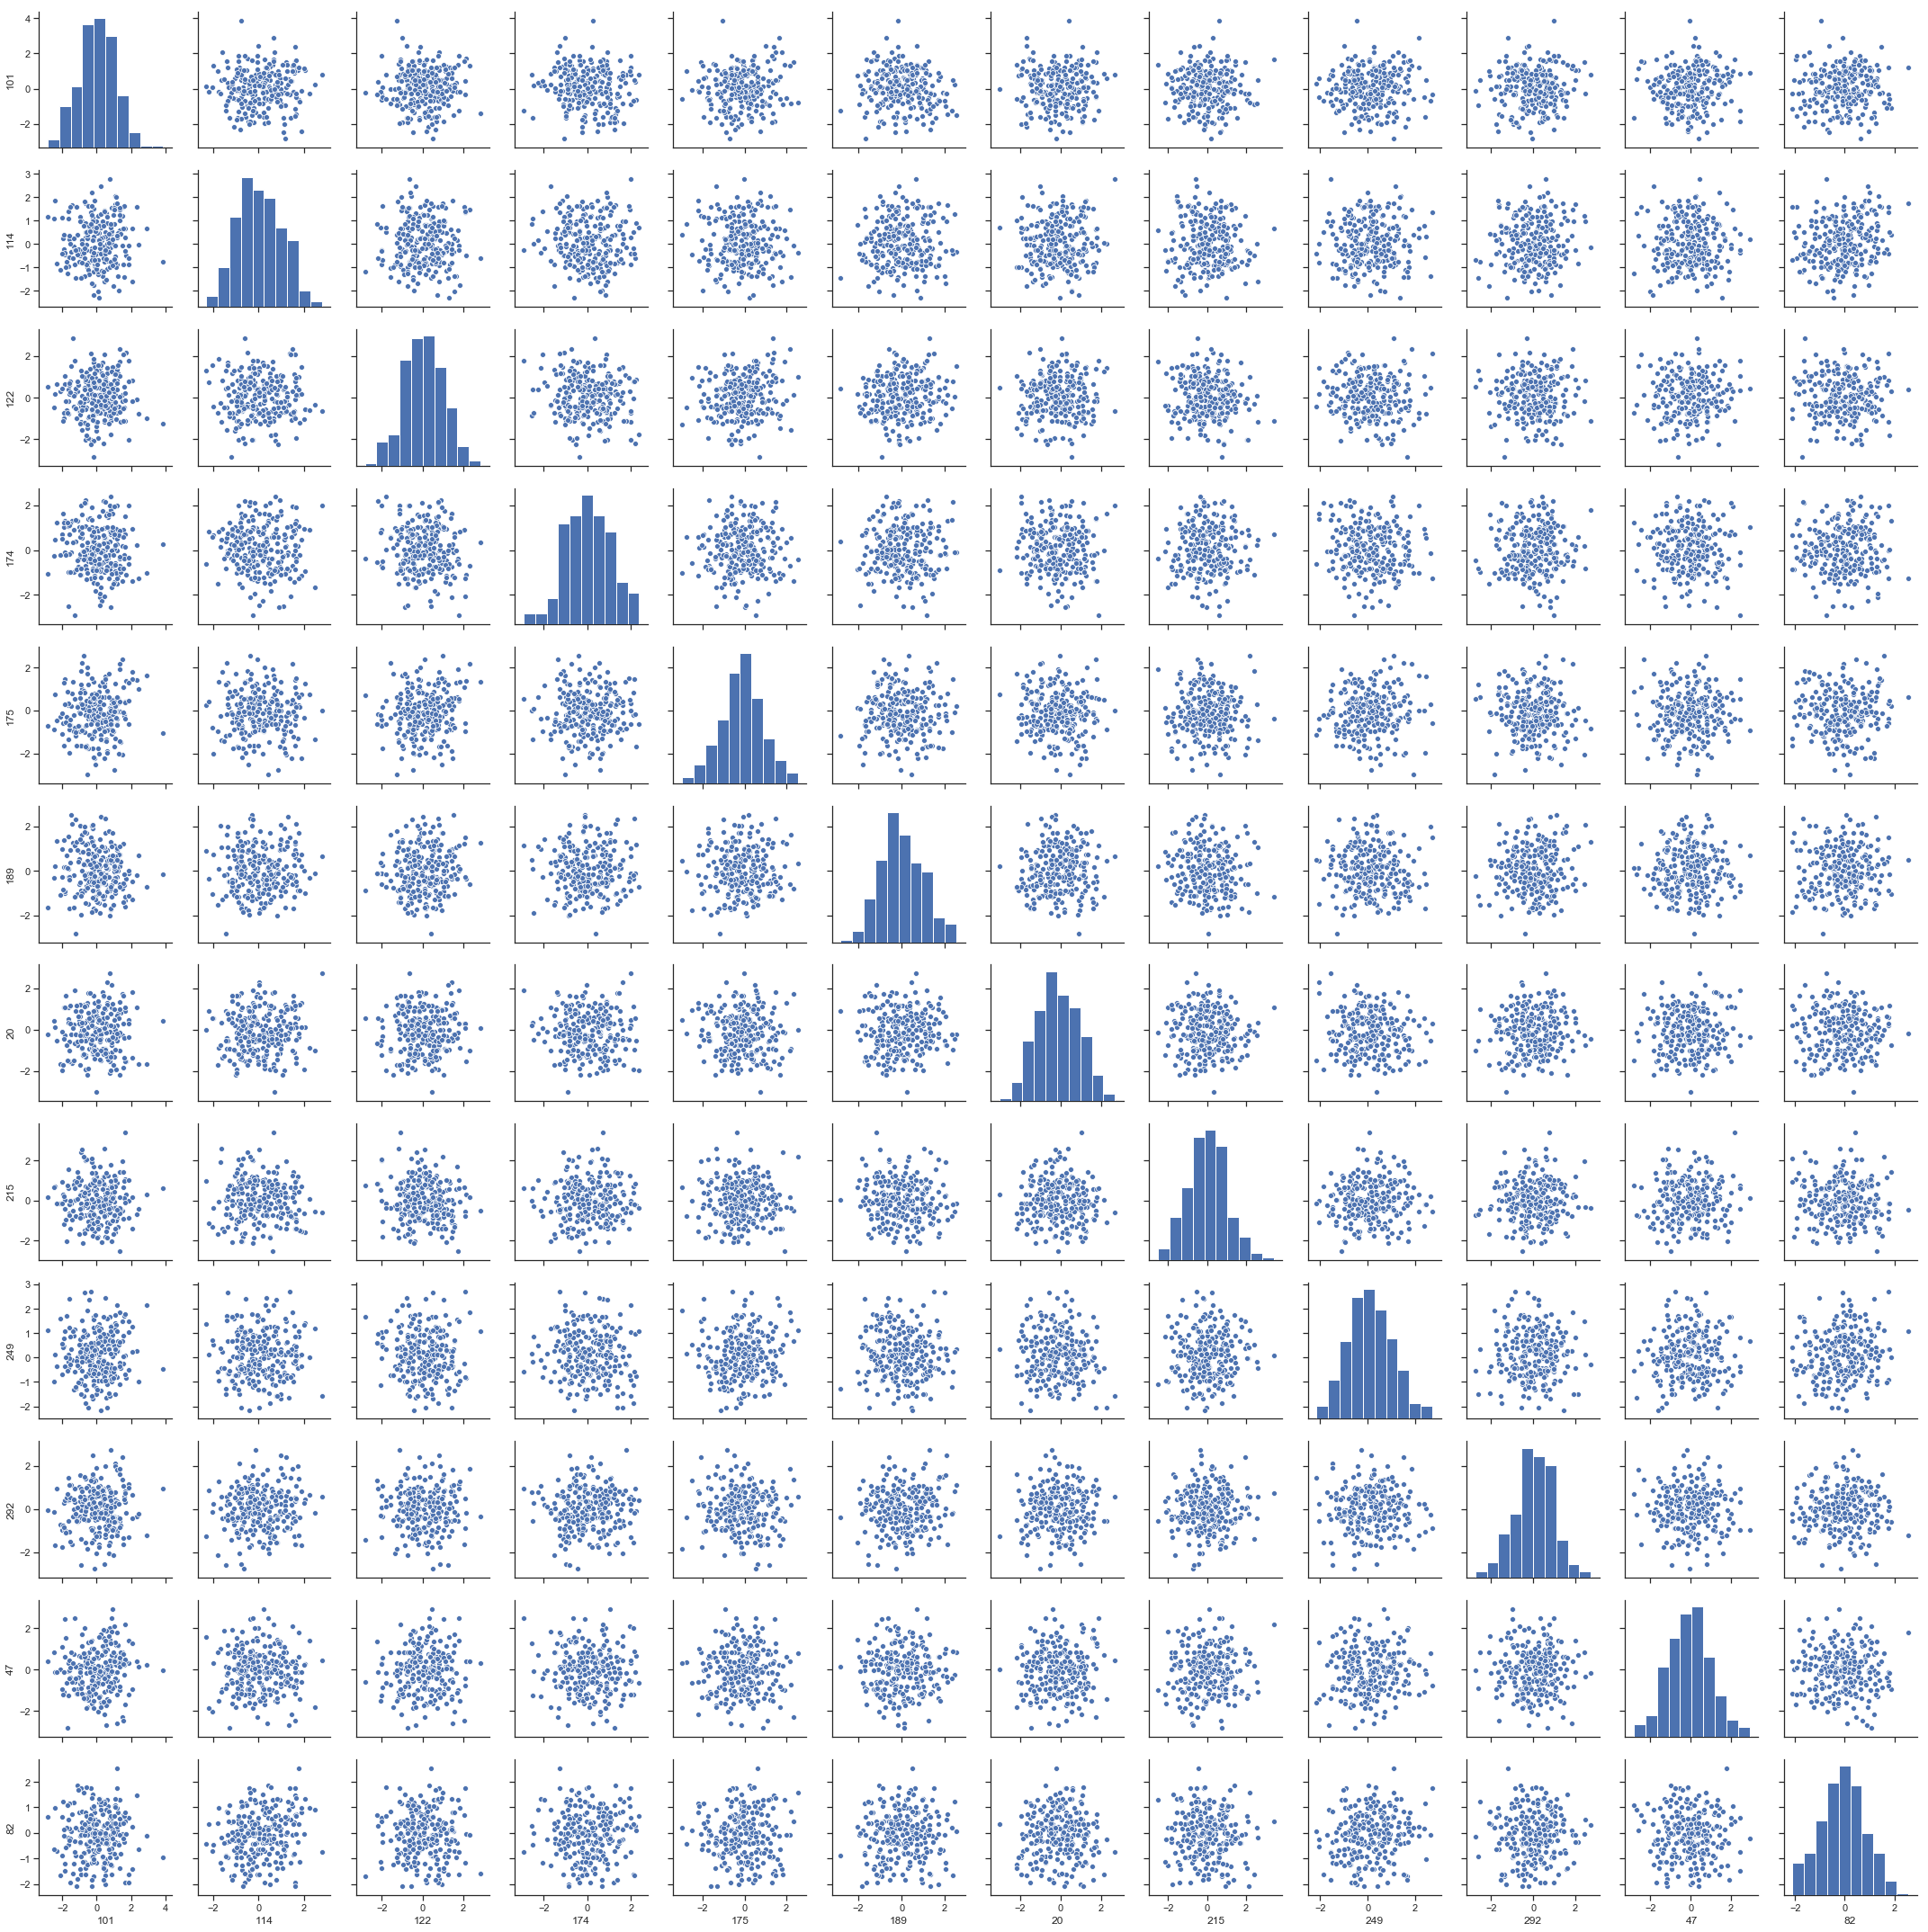

In [2]:
random.seed(432532) # comment out for new random samples

rand_feats = [str(x) for x in random.sample(range(0,300), 12)]
dfp = gather(df[["id","target"]+rand_feats], "feature", "value", rand_feats)
sns.set(style="ticks")

sns.pairplot(spread(dfp, "id", "feature", "value").drop("id",1))